Dataset: https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html

Imports

In [0]:
import pandas as pd # Importa o Pandas

arquivo = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv' # Nome e local do arquivo

df = pd.read_csv(arquivo) # Cria um dataframe do pandas

In [2]:
df.shape # Verifica o número de linhas e colunas

(887, 8)

Verificar os primeiros itens do dataframe

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


Principais estatística do dataframe

In [4]:
df = df.drop('Name', axis=1)
df.describe() 

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


Verificar se há valores em branco (NaN)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Sex                      887 non-null    object 
 3   Age                      887 non-null    float64
 4   Siblings/Spouses Aboard  887 non-null    int64  
 5   Parents/Children Aboard  887 non-null    int64  
 6   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.6+ KB


Gerando visualizações

In [6]:
import seaborn as sns # Importa a biblioteca Seaborn (para plot)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
sns.set(style='ticks') # Define o "estilo" que será usado nos gráficos


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


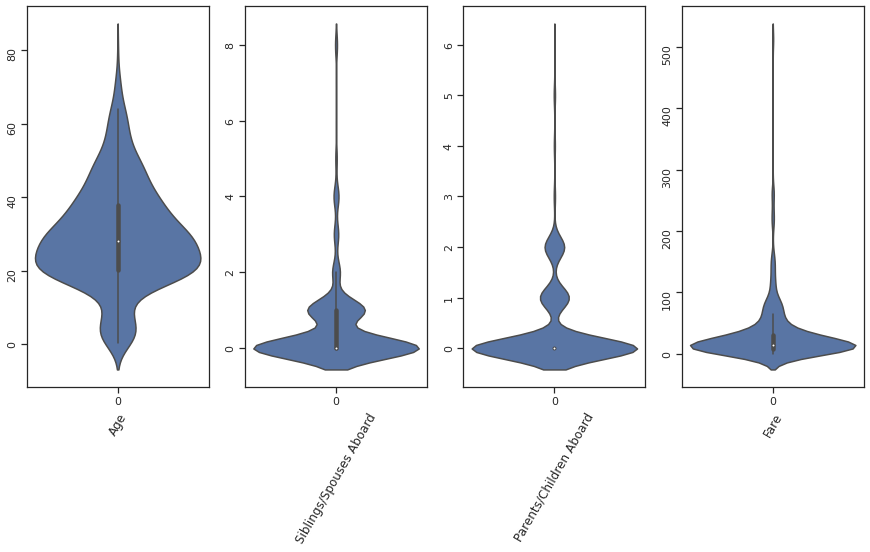

In [7]:
for pos in range(3, 7):
  plt.subplot(1, 4, pos-2)
  sns.violinplot(data=df.iloc[:, pos])
  plt.xlabel(df.columns[pos], rotation=60)
  plt.yticks(rotation='vertical')

plt.show()

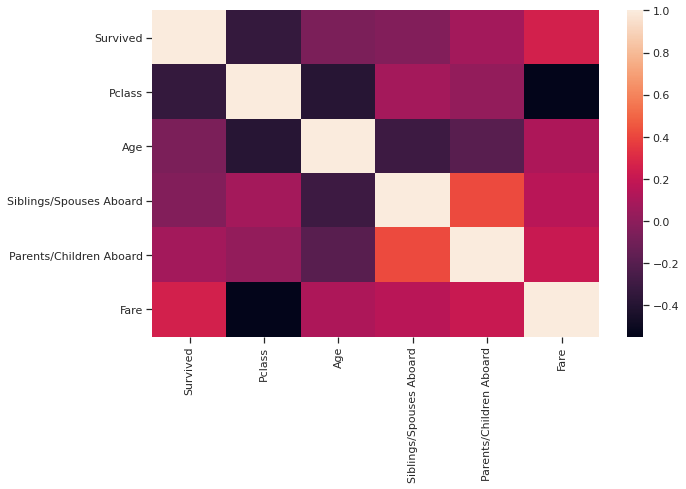

In [8]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(df.corr())

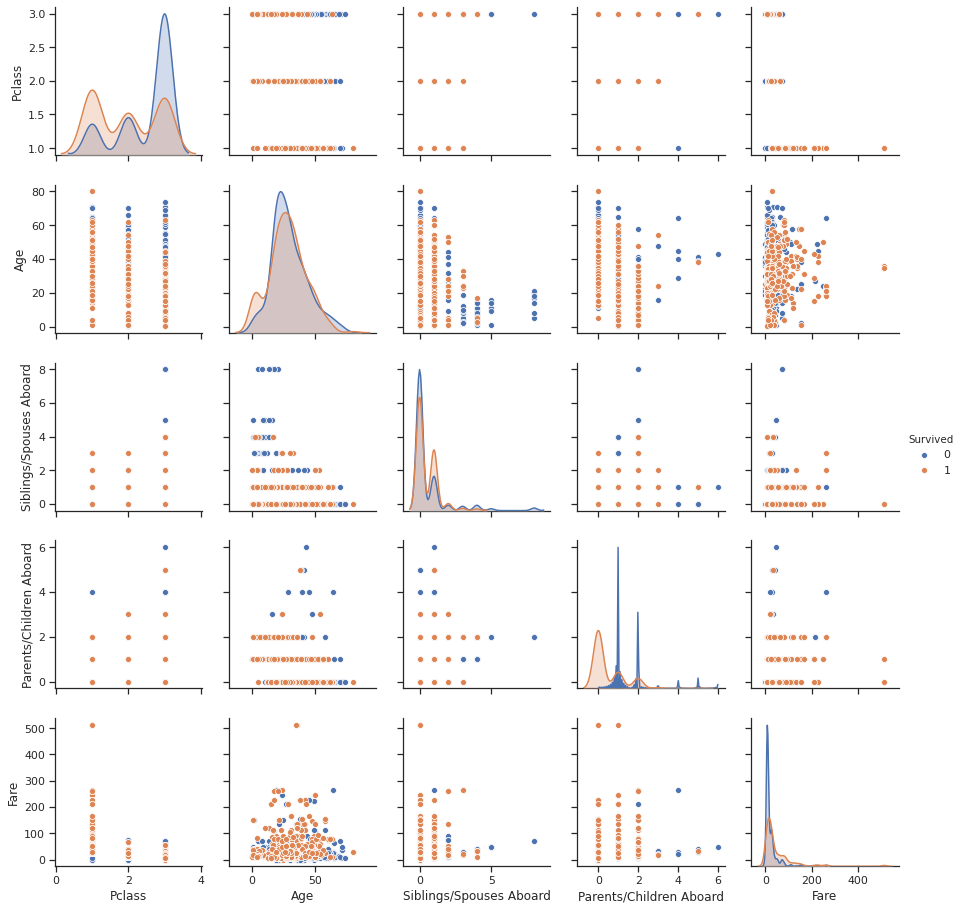

In [9]:
sns.pairplot(df, hue='Survived')

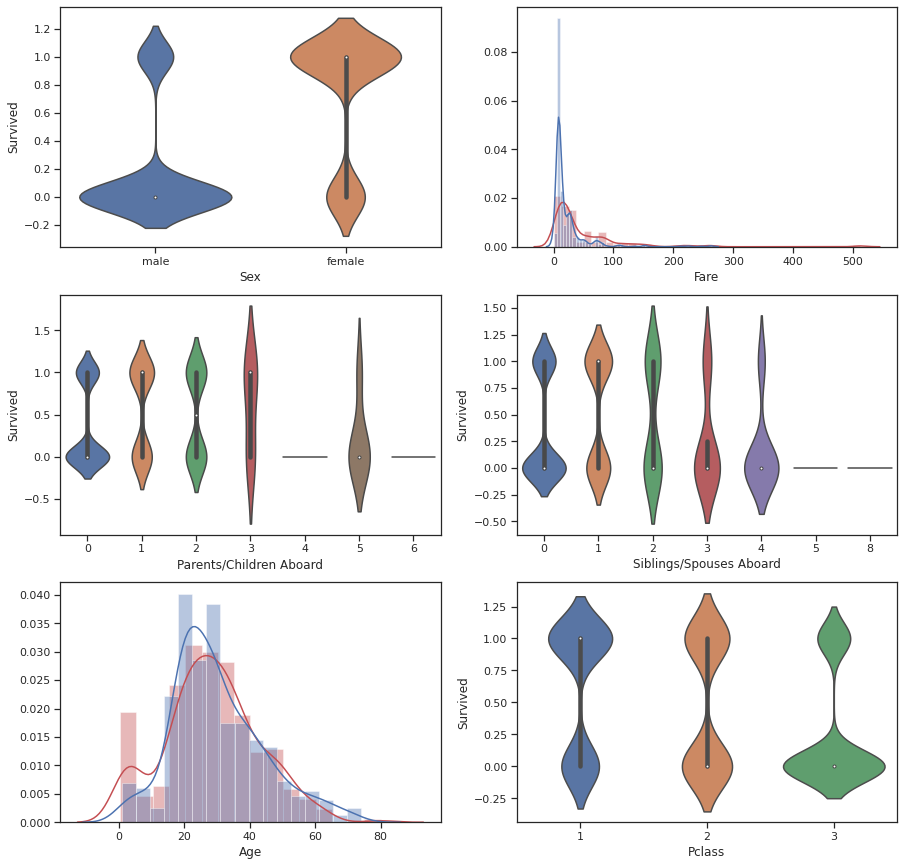

In [10]:
plt.rcParams["figure.figsize"] = (15,15)

plt.subplot(3, 2, 1)
sns.violinplot(df['Sex'], df['Survived'])
plt.subplot(3, 2, 2)
sns.distplot(df['Fare'][df['Survived']==1], color='r')
sns.distplot(df['Fare'][df['Survived']==0], color='b')
plt.subplot(3, 2, 3)
sns.violinplot(df['Parents/Children Aboard'], df['Survived'])
plt.subplot(3, 2, 4)
sns.violinplot(df['Siblings/Spouses Aboard'], df['Survived'])
plt.subplot(3, 2, 5)
sns.distplot(df['Age'][df['Survived']==1], color='r')
sns.distplot(df['Age'][df['Survived']==0], color='b')
plt.subplot(3, 2, 6)
sns.violinplot(df['Pclass'], df['Survived'])

plt.show()

Mapendo valores de "sex"

In [0]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [12]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


In [13]:
df.shape

(887, 7)

# Modelo

In [0]:
y = df['Survived']
X = df.drop(['Survived'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split # Importa parte do sklearn para dividir os dados de entrada entre treino e teste

In [0]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=0) # Divide os dados de entrada entre treino e teste

In [0]:
from lightgbm import LGBMClassifier

In [0]:
modelo = LGBMClassifier()

In [19]:
modelo.fit(X_treino, y_treino)
modelo.score(X_teste, y_teste)

0.8243243243243243

# Otimizando hiperparâmetros

Com base no tutorial do [Mario Filho](http://mariofilho.com).

In [20]:
!pip install scikit-optimize
from skopt import gp_minimize 

In [21]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    subsample_freq = params[5]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                         subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=subsample_freq, 
                         n_estimators=100)
    
    mdl.fit(X_treino, y_treino)
    
    return -mdl.score(X_teste, y_teste)

space = [(1e-3, 1), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0), # colsample bytree
         (1, 5)] # colsample bytree

resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=50, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.9971876261279299, 120, 14, 0.9990884895579377, 0.3124800792567785, 3] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0364
Function value obtained: -0.7568
Current minimum: -0.7568
Iteration No: 2 started. Evaluating function at random point.
[0.3885228304208455, 86, 94, 0.8539953708517165, 0.3819461652390477, 3] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0227
Function value obtained: -0.8243
Current minimum: -0.8243
Iteration No: 3 started. Evaluating function at random point.
[0.4440094408857772, 31, 54, 0.9182639233502715, 0.5114843271882895, 3] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0290
Function value obtained: -0.8288
Current minimum: -0.8288
Iteration No: 4 started. Evaluating function at random point.
[0.9391886616342023, 100, 72, 0.8126196287404969, 0.18352072777666414, 3] 

Iteration No: 4 ended. Evaluation done at random point

In [22]:
resultados_gp.x

[0.5600528527352706, 78, 93, 0.920410268901516, 1.0, 2]

# Adaptando modelo

Cross validation

In [23]:
from sklearn.model_selection import cross_val_score
mdl = LGBMClassifier(learning_rate=0.2829, num_leaves=128, min_child_samples=58,
                     subsample=0.8722, colsample_bytree=0.5265, random_state=0, subsample_freq=1,
                     n_estimators=100)
    
scores = cross_val_score(mdl, X, y, cv=5, scoring='accuracy')

print(scores.mean())

0.8365771599060497
